In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler, LabelBinarizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import FunctionTransformer

from sklearn import set_config
set_config(display='diagram')
# ------------------------------------------
import nltk
import sys
import random

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

sys.path.append('..')
import utils

## PROPIAS
from utils import RemoveStopWords
from utils import FeatureExtractionTwitts
from utils import LemmantizerTransformer
from utils import Vectorizer
from utils import ColumnSelectedTransformer
from sklearn.compose import TransformedTargetRegressor

from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import HistGradientBoostingClassifier
from utils import KerasCustomClassifier

import glob

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html

In [2]:
df = pd.read_csv('training_tweets.csv', index_col = 0)
df;

In [3]:
df.content.to_csv('raw_tweets.csv')

In [4]:
groups_classes = {
                    'happiness' : 'positiva',
                    'surprise'  : 'positiva',
                    'love'      : 'positiva',
                    'fun'       : 'positiva',
                    'relief'    : 'positiva',
                    'enthusiasm': 'positiva',
                    'worry'     : 'negativa',
                    'hate'      : 'negativa',
                    'sadness'   : 'negativa',
                    'empty'     : 'negativa',
                    'boredom'   : 'negativa',
                    'anger'     : 'negativa',
                    'neutral'   : 'neutral'
                }
neutral_class_name = 'neutral'
target_var_name = 'sentiment'
target_mapping = [('positiva',1),('negativa',0)]
chars_to_replace = [
                        ('ï¿½',''),
                        ('&quot;',''),
                        ('&lt;3','<3'), 
                        ('&lt;/3','</3'), 
                        ('&amp;','&'),
                        ('&gt;','>'),
                        ('&lt;','<')
                    ]

In [5]:
df_preprocess = Pipeline(steps=[
                ('regroup_classes', 
                    FunctionTransformer(
                        utils.multi_class_remapping, 
                        kw_args={
                            'group_classes': groups_classes,
                            'var_name': target_var_name,
                            'neutral_class': neutral_class_name,
                            'random_state': 42
                            })),
                ('encoding', FunctionTransformer(
                        utils.target_encoding,
                        kw_args={
                            'column_to_encode': 'sentiment_remapped', 'mapping':target_mapping})),
])

df = df_preprocess.fit_transform(df) #
df
# Este debiese ser la primera transformación, no se si serializar esto o no pero habría que indicar que es necesario aplicarlo a df para poder continuar.

,content,sentiment,sentiment_remapped
34723,Happy Mama's day to all mothers,love,1
17493,@LysdelTellez I am lost. Please help me find a...,worry,0
20198,"@BoomKatt yes yes I AM, networking whore to th...",happiness,1
6855,you@snapplynn Wish that would have been your t...,neutral,0
5924,now i am doing the MicroEconomics project iha...,worry,0
...,...,...,...
16469,I do not want to work tomorrow!,sadness,0
36006,@KandyBee we shuld do a dance like that its s...,fun,1
22647,"Photo: Got my prints a few days ago, ready for...",happiness,1
21478,@tove_liden Thanks for the follow Tove!,fun,1


In [6]:
X = df[['content']]
y = df.sentiment_remapped
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

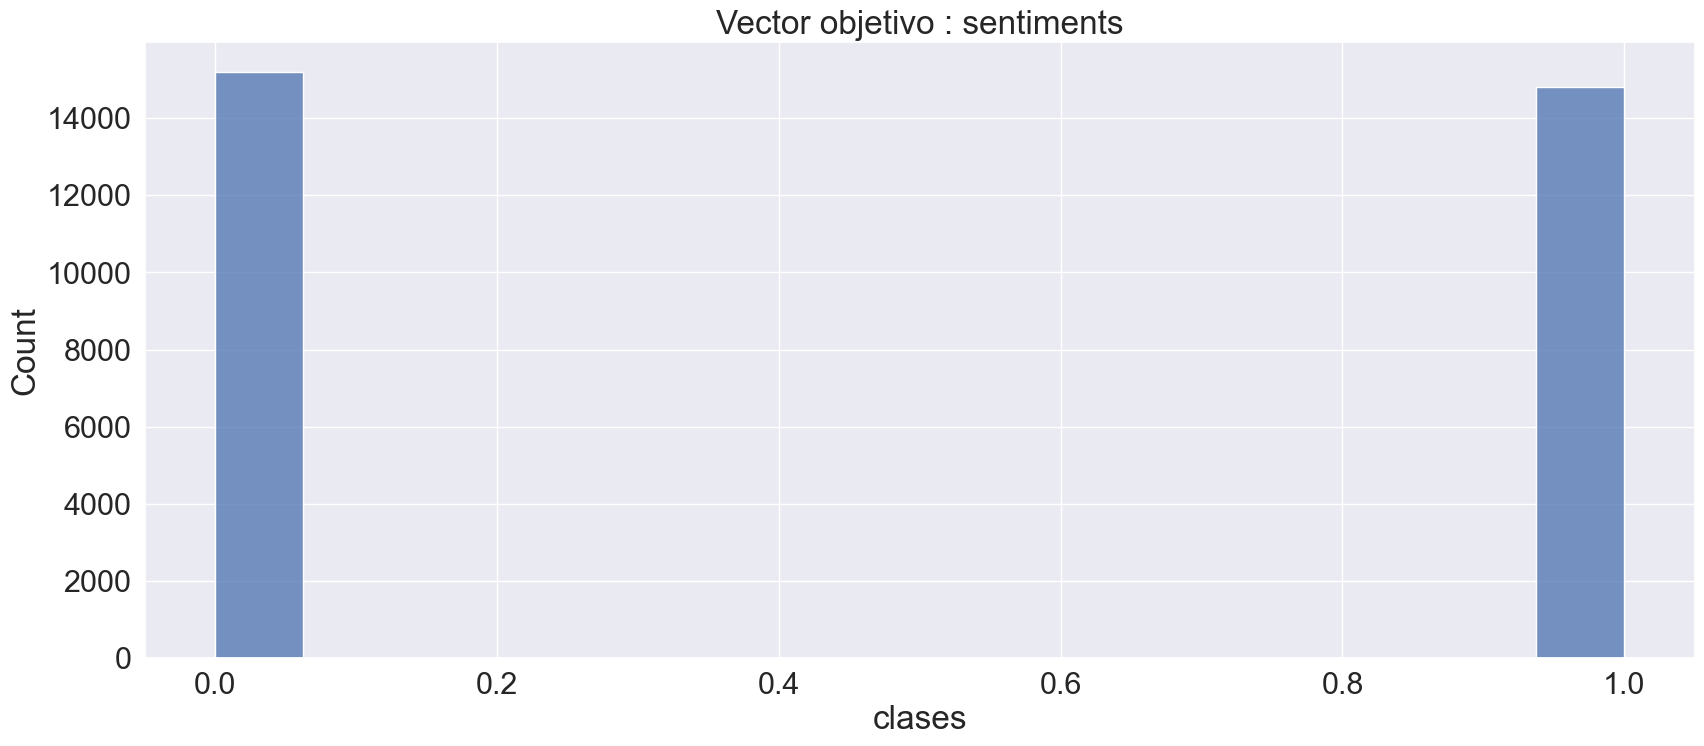

In [7]:
#Visualización de el vector objetivo:
sns.set(font_scale=2)
plt.figure(figsize=(20, 8))
sns.histplot(y); # Categoría uno muchos menos casos que categoría 0.
plt.title("Vector objetivo : sentiments")
plt.xlabel("clases");

In [9]:
preprocessing = Pipeline(steps=[
                ('rc', FunctionTransformer(utils.remove_chars, kw_args={'var_name': 'content', 'new_var_name': 'content_mod', 'char_list': chars_to_replace})),
                ('ra', FunctionTransformer(utils.remove_arrobas, kw_args= {'var_name':'content_mod', 'new_var_name': 'content_mod'})),
                ('rl', FunctionTransformer(utils.remove_links, kw_args={'var_name': 'content_mod', 'new_var_name': 'content_mod'})),
                # ('rsw', RemoveStopWords(text_columns = ['content_mod'])),
                ('lt', LemmantizerTransformer(text_columns = ["content_mod"], stemmer='wnl')),
])

# Si se quiere ver los resultados de las limpiezas de los textos, comentar la linea de ColumnSelectedTransformer y luego ver el dataframe. También se pueden ver los reportes generados en csv y txt en la carpeta raíz.

feature_extraction = Pipeline(steps=[
                ('fet_1', FeatureExtractionTwitts(text_column="content",features_to_extract=["arrobas_count", "hashtag_count", "is_reply", "is_rt", "twitt_length"])),
                ('fet_2', FeatureExtractionTwitts(text_column="content_mod",features_to_extract = ["subjectivity", "polarity"])),
                ('vec', Vectorizer(vect_type='tfid', text_column="content_mod", min_df=15, max_df=0.7, ngram_range=(1,3))),
                ('fs', ColumnSelectedTransformer(vars_prefix='var_'))
])

---
# Clasificadores Base

In [10]:
mnb     = MultinomialNB()
gnb     = GaussianNB() # 59 seg train
knc     = KNeighborsClassifier()
svc     = SVC(random_state=42, probability=True)
gbc     = GradientBoostingClassifier(random_state=42)
# funciona particularmente bien stackeando xgboost
lr      = LogisticRegression(random_state=42, C=0.01) # gnb
rfc     = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10) # 61 train
hgnb    = HistGradientBoostingClassifier(random_state=42)  # 1:43 min train

# metaestimator stacking
sc_1 = StackingClassifier(estimators=[("lr", lr), ("rfc", rfc)], final_estimator=gbc, cv=5)
# En este caso se eligieron estimadores de naturaleza distinta en los estimadores. En el final estimator se selecciono un gradient boosting.

# metaestimator voting
vc_1 = VotingClassifier([("lr", lr), ("knc", knc), ("gbc", gbc)], voting="hard", n_jobs=-1)
# Se eligio un número impar de modelos para que siempre exista mayoría. 

# metaestimator boosting
bc_1 = AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=1, n_estimators=5), random_state=42, n_estimators=100, learning_rate=1)

nn_arch = {
    'input_layer'       : ('input_dense', 32, 'relu'),
    'drop_1'            : ('dropout', .2),
    'output_layer'      : ('dense', 1, 'sigmoid')
}

kcc = KerasCustomClassifier(    
                                nn_arch, 
                                loss='binary_crossentropy',
                                optimizer='Adam',
                                metrics='accuracy',
                                net_name='twitter_keras_net',
                                epochs=10
                            )

---
### Optimización del sub-pipeline de preprocessing y feature extraction

In [ ]:
params = {
    'preprocessing__rsw': [RemoveStopWords(text_columns = ['content_mod']), None],
    'preprocessing__lt' : [LemmantizerTransformer(text_columns=['content_mod'], stemmer='ps'), LemmantizerTransformer(text_columns=['content_mod'], stemmer='wnl'), LemmantizerTransformer(text_columns=['content_mod'], stemmer='sno'), None],
    'feature_extraction__vec__vect_type': ['tfid'],
    'feature_extraction__vec__min_df': [5, 10, 15]
}

pipe = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('feature_extraction', feature_extraction),
    ('model', rfc)
])

search = GridSearchCV(pipe, params, cv=5, scoring='accuracy', n_jobs=4, verbose=10)
search.fit(X_train, y_train)

utils.save_bytes_variable({'best_params': search.best_params_, 'best_score': search.best_score_, 'results': pd.DataFrame(search.cv_results_), 'params': params}, 'gridsearch_preprocessing_twitter.pickle')


---
### GridSearch de Modelo 1: Stacking

In [ ]:
pipe_stacking = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('feature_extraction', feature_extraction),
    ('model', sc_1)
])

params_stacking = {
                    'model__final_estimator__n_estimators': [50, 100, 500],
                    'model__final_estimator__max_depth': [5, 10, 50]
                }

search_stacking = GridSearchCV(pipe_stacking, params_stacking, cv=5, scoring='accuracy', n_jobs=-1)
search_stacking.fit(X_train, y_train)

utils.save_bytes_variable({'best_params': search_stacking.best_params_, 'best_score': search_stacking.best_score_, 'results': pd.DataFrame(search_stacking.cv_results_), 'params': params}, 'gridsearch_stacking_twitter.pickle')

---
### GridSearch de Modelo 2: Voting

In [ ]:
pipe_voting = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('feature_extraction', feature_extraction),
    ('model', gbc)
])

params_voting = {
                    'model__voting': ['hard','soft']
                }

search_voting = GridSearchCV(pipe_voting, params_voting, cv=5, scoring='accuracy', n_jobs=-1)

search_voting.fit(X_train, y_train)

utils.save_bytes_variable({'best_params': search_voting.best_params_, 'best_score': search_voting.best_score_, 'results': pd.DataFrame(search_voting.cv_results_), 'params': params_voting}, 'gridsearch_voting_twitter.pickle')

---
### GridSearch de Modelo 3: GBoost

In [ ]:
pipe_gboost = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('feature_extraction', feature_extraction),
    ('model', gbc)
])

params_gboost = {
                    'model__n_estimators':[10,50, 100, 200],
                    'model__learning_rate':[0.01, 0.1, 0.5, 1],
                    'model__max_depth':[1,2,3,4,5]
                }

search_gboost = GridSearchCV(pipe_gboost, params_gboost, cv=5, scoring='accuracy', n_jobs=-1)
search_gboost.fit(X_train, y_train)

utils.save_bytes_variable({'best_params': search_gboost.best_params_, 'best_score': search_gboost.best_score_, 'results': pd.DataFrame(search_gboost.cv_results_), 'params': params_gboost}, 'gridsearch_gboost_twitter.pickle')

---
### GridSearch de Modelo 4: Adaboost

In [ ]:
pipe_adaboost = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('feature_extraction', feature_extraction),
    ('model', bc_1)
])

params_adaboost = {
                    'model__n_estimators':[10,50, 100, 200],
                    'model__learning_rate':[0.01, 0.1, 0.5, 1]
                }

search_adaboost = GridSearchCV(pipe_adaboost, params_adaboost, cv=5, scoring='accuracy', n_jobs=-1)
search_adaboost.fit(X_train, y_train)

utils.save_bytes_variable({'best_params': search_adaboost.best_params_, 'best_score': search_adaboost.best_score_, 'results': pd.DataFrame(search_adaboost.cv_results_), 'params': params_adaboost}, 'gridsearch_adaboost_twitter.pickle')

---
### GridSearch de Modelo 5: Red Neuronal

In [ ]:
pipe_nn = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('feature_extraction', feature_extraction),
    ('model', kcc)
])

nn_arch_1 = {
    'input_layer'       : ('input_dense', 32, 'relu'),
    'drop_1'            : ('dropout', .2),
    'output_layer'      : ('dense', 1, 'sigmoid')
}

nn_arch_2 = {
    'input_layer'       : ('input_dense', 16, 'relu'),
    'drop_1'            : ('dropout', .2),
    'output_layer'      : ('dense', 1, 'sigmoid')
}

nn_arch_3 = {
    'input_layer'       : ('input_dense', 32, 'relu'),
    'drop_1'            : ('dropout', .1),
    'output_layer'      : ('dense', 1, 'sigmoid')
}

nn_arch_4 = {
    'input_layer'       : ('input_dense', 16, 'relu'),
    'drop_1'            : ('dropout', .1),
    'output_layer'      : ('dense', 1, 'sigmoid')
}

nn_arch_5 = {
    'input_layer'       : ('input_dense', 32, 'relu'),
    'drop_1'            : ('dropout', .4),
    'output_layer'      : ('dense', 1, 'sigmoid')
}

nn_arch_6 = {
    'input_layer'       : ('input_dense', 16, 'relu'),
    'drop_1'            : ('dropout', .4),
    'output_layer'      : ('dense', 1, 'sigmoid')
}

params_nn = {   
                'model__epochs': [5, 10, 20],
                'model__nn_arch':[nn_arch_1, nn_arch_2, nn_arch_3, nn_arch_4, nn_arch_5, nn_arch_6],
            }

search_nn = GridSearchCV(pipe_nn, params_nn, cv=5, scoring='accuracy', n_jobs=-1)
search_nn.fit(X_train, y_train)

utils.save_bytes_variable({'best_params': search_nn.best_params_, 'best_score': search_nn.best_score_, 'results': pd.DataFrame(search_nn.cv_results_), 'params': params_nn}, 'gridsearch_nn_twitter.pickle')


---

# Serialización de los 2 mejores modelos

### Comparativa entre los 5 modelos propuestos con los resultados obtenidos en el gridsearch

In [35]:
utils.load_bytes_variable('gridsearch_gboost_twitter.pickle')['best_params']

{'model__learning_rate': 0.1,
 'model__max_depth': 4,
 'model__n_estimators': 200}

In [34]:
print('Comparación por ACCURACY')
for file in glob.glob("*twitter.pickle*"):
    if 'preprocessing' not in file:
        dct = utils.load_bytes_variable(file)
        print(f'{dct["best_score"]} - {file}')


Comparación por ACCURACY
0.6772083333333333 - gridsearch_adaboost_twitter.pickle
0.6701666666666666 - gridsearch_gboost_twitter.pickle
0.6832916666666666 - gridsearch_nn_twitter.pickle
0.6530833333333332 - gridsearch_stacking_twitter.pickle
0.6528333333333334 - gridsearch_voting_twitter.pickle


Tratamos de serializar los modelos con mejor desempeño entre los cuales está la red neuronal implementada en Keras, pero nos fue imposible guardarla de manera apropiada para que pudiera ser testeada posteriormente.

Teniendo en cuenta esto y bajo el criterio de seleccionar los modelos con mejor desempeño en el grid search, se determina que serializaremos los siguientes modelos:

- Gradient boosting con los siguientes parámetros:
```py
  {
    'model__learning_rate': 0.1,
    'model__max_depth': 4,
    'model__n_estimators': 200
  }
```

- Adaboost con los siguientes parámetros:
```py
  {
    'model__learning_rate': 0.5,
    'model__n_estimators': 200
  }
```

In [18]:
best_pipe_1 = Pipeline(steps=[
                                ('preprocessing', preprocessing),
                                ('feature_extraction', feature_extraction),
                                ('model', GradientBoostingClassifier(
                                    learning_rate=0.1,
                                    max_depth=4,
                                    n_estimators=200,
                                    random_state=42))
                            ])

best_pipe_2 = Pipeline(steps=[
                                ('preprocessing', preprocessing),
                                ('feature_extraction', feature_extraction),
                                ('model', AdaBoostClassifier(
                                    base_estimator = RandomForestClassifier(
                                        max_depth=1, 
                                        n_estimators=5
                                        ), 
                                    random_state=42,
                                    n_estimators=200,
                                    learning_rate=0.5)
                                )
                            ])



best_pipe_1.fit(X, y)
best_pipe_2.fit(X, y)

utils.save_bytes_variable({'best_pipe_1': best_pipe_1, 'best_pipe_2': best_pipe_2, 'target_process': df_preprocess}, 'twitter_best_models.pickle')


c:\Users\tomas\Desktop\Tareas Data Science - Desafío Latam\machine_learning\prueba\twitter\..\utils.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[new_var_name] = XR.str.lower()
c:\Users\tomas\Desktop\Tareas Data Science - Desafío Latam\machine_learning\prueba\twitter\..\utils.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[new_var_name]= X[var_name].apply(
c:\Users\tomas\Desktop\Tareas Data Science - Desafío Latam\machine_learning\prueba\twitter\..\utils.py:228: SettingWithCopyWarning: 
A 

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('rc',
                                  FunctionTransformer(func=<function remove_chars at 0x000001FE42AFAC20>,
                                                      kw_args={'char_list': [('ï¿½',
                                                                              ''),
                                                                             ('&quot;',
                                                                              ''),
                                                                             ('&lt;3',
                                                                              '<3'),
                                                                             ('&lt;/3',
                                                                              '</3'),
                                                                             ('&amp;',
                                                                              '&'),
                                                                             ('&gt;',
                                                                              '>'),
                                                                             ('&lt;',
                                                                              '<')],
                                                               'new_var_name': 'content_mod',
                                                               'var_name': 'content'})),
                                 ('ra',
                                  FunctionTransformer(func=<function remove_arrobas...
                                                                               'polarity'],
                                                          text_column='content_mod')),
                                 ('vec',
                                  Vectorizer(max_df=0.7, min_df=15,
                                             ngram_range=(1, 3),
                                             text_column='content_mod',
                                             vect_type='tfid')),
                                 ('fs',
                                  <utils.ColumnSelectedTransformer object at 0x000001FE42EFDFC0>)])),
                ('model',
                 AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=1,
                                                                          n_estimators=5),
                                    learning_rate=0.5, n_estimators=200,
                                    random_state=42))])

In [23]:
pipeline_premodel = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('feature_extraction', feature_extraction)
])
pipeline_premodel.fit(X, y)



c:\Users\tomas\Desktop\Tareas Data Science - Desafío Latam\machine_learning\prueba\twitter\..\utils.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[new_var_name] = XR.str.lower()
c:\Users\tomas\Desktop\Tareas Data Science - Desafío Latam\machine_learning\prueba\twitter\..\utils.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[new_var_name]= X[var_name].apply(
c:\Users\tomas\Desktop\Tareas Data Science - Desafío Latam\machine_learning\prueba\twitter\..\utils.py:228: SettingWithCopyWarning: 
A 

In [24]:
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
import sys
sys.path.append('..')
import utils
from keras.models import load_model

nombre_archivo_sin_keras = 'twitter_best_models_w_o_keras.pickle'
nombre_archivo_keras = 'twitter_best_models_keras.h5'

model_keras = load_model(nombre_archivo_keras)
models = utils.load_bytes_variable(nombre_archivo_sin_keras)
pipeline_prekeras = models['pipeline_prekeras']

# cambiar nombre csv por el del archivo test
df_twitter_test = pd.read_csv('training_tweets.csv', index_col=0) 
df_twitter_test = models['target_process'].transform(df_twitter_test)

X = df_twitter_test[['content']]
y = df_twitter_test.sentiment_remapped

X_tr_keras = pipeline_prekeras.transform(X)

utils.test_function(model_keras, X_tr_keras, y.round()) # Predicciones modelo 1
utils.test_function(models['best_pipe_2'], X, y) # Predicciones modelo 2


c:\Users\tomas\Desktop\Tareas Data Science - Desafío Latam\machine_learning\prueba\twitter\..\utils.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[new_var_name] = XR.str.lower()
c:\Users\tomas\Desktop\Tareas Data Science - Desafío Latam\machine_learning\prueba\twitter\..\utils.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[new_var_name]= X[var_name].apply(
c:\Users\tomas\Desktop\Tareas Data Science - Desafío Latam\machine_learning\prueba\twitter\..\utils.py:228: SettingWithCopyWarning: 
A 

938/938 [==============================] - 2s 2ms/step
test


ValueError: Classification metrics can't handle a mix of binary and continuous targets